# 04. PyTorch Custom Datasets Video Notebook 

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

On of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources**:
- Book version: https://www.learnpytorch.io/04_pytorch_custom_datasets
- Ground truth: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.7.1+cu126'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data
 
 Our dataset is a subset of Food101 dataset.

 Food 101 starts at 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small sclae and then increase the scale
when necessary.

The whole point is to speed up how fast you can experiment

In [3]:
import requests
import zipfile
from pathlib import Path

DATA_PATH = Path("data/")
IMAGE_PATH = DATA_PATH / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...

if IMAGE_PATH.is_dir():
    print(f"{IMAGE_PATH} directory already exists... Skipping download")
else:
    print(f"{IMAGE_PATH} does not exist, creating one...")
    IMAGE_PATH.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, and sushi data
with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, and sushi data")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(IMAGE_PATH)

data/pizza_steak_sushi directory already exists... Skipping download
Unzipping pizza, steak, and sushi data...


## 2. Data preparation/exploration

In [4]:
import os 


def walk_through_dir(dir_path):
    """Walks through `dir_path` returning its contents."""
    for dir_paths, dir_names, file_names, in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories, and {len(file_names)} images in {dir_paths}")

In [5]:
walk_through_dir(IMAGE_PATH)

There are 2 directories, and 0 images in data/pizza_steak_sushi
There are 3 directories, and 0 images in data/pizza_steak_sushi/test
There are 0 directories, and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories, and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories, and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories, and 0 images in data/pizza_steak_sushi/train
There are 0 directories, and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories, and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories, and 72 images in data/pizza_steak_sushi/train/sushi


In [6]:
#Setup train and testing paths

train_dir = IMAGE_PATH / "train"
test_dir = IMAGE_PATH / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with iamges, let's open the image with Pythons' PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/sushi/1742201.jpg
Image class: sushi
Image height: 512
Image width: 512


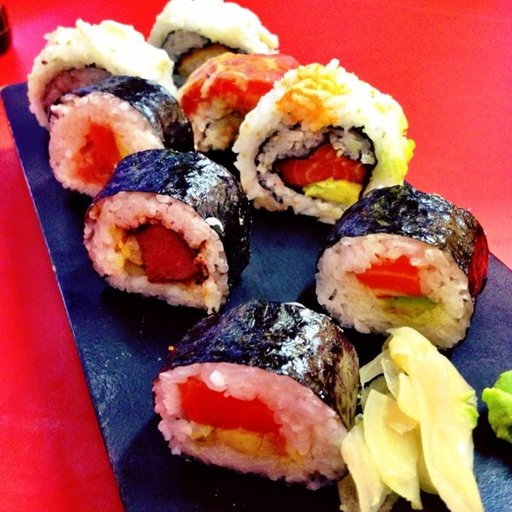

In [7]:
import random
from PIL import Image


# random.seed(42)

# 1. Get all the image paths
image_path_list = list(IMAGE_PATH.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

array([[[252,  19,  15],
        [250,  21,  16],
        [249,  26,  19],
        ...,
        [251,  56,  96],
        [249,  54,  98],
        [255,  61, 105]],

       [[251,  22,  19],
        [250,  22,  19],
        [245,  26,  20],
        ...,
        [252,  57,  97],
        [249,  54,  96],
        [255,  61, 105]],

       [[246,  22,  20],
        [243,  24,  20],
        [239,  24,  19],
        ...,
        [253,  58,  98],
        [249,  54,  96],
        [255,  61, 103]],

       ...,

       [[253,  47,  70],
        [255,  51,  74],
        [255,  49,  72],
        ...,
        [110, 151, 183],
        [108, 149, 179],
        [ 91, 132, 160]],

       [[245,  39,  62],
        [244,  38,  61],
        [248,  42,  65],
        ...,
        [103, 144, 176],
        [100, 141, 169],
        [113, 157, 182]],

       [[248,  42,  65],
        [243,  37,  60],
        [251,  45,  68],
        ...,
        [126, 167, 197],
        [ 99, 143, 170],
        [114, 158, 183]]

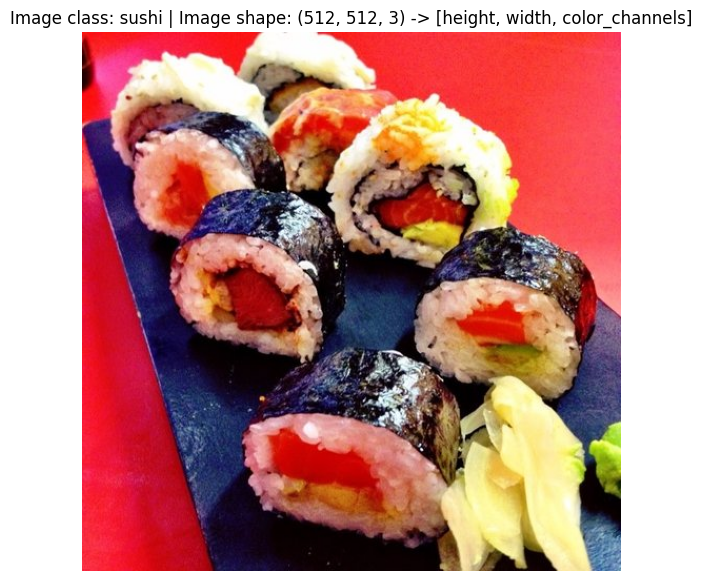

In [8]:
# Plotting a random image with numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt


# Turn the img into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
img_as_array

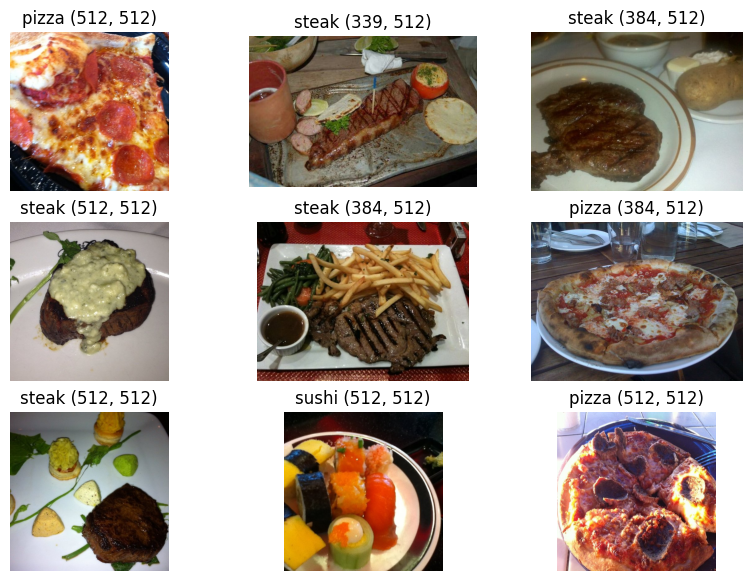

In [9]:
# Plotting random images

fig = plt.figure(figsize=(10,7))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_img_path = random.choice(image_path_list)
    img_class = random_img_path.parent.stem
    fig.add_subplot(rows, cols, i)
    random_img = Image.open(random_img_path)
    plt.imshow(random_img)
    plt.title(f"{img_class} ({random_img.height}, {random_img.width})")
    plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`,
we'll call this `Datasets` and `DataLoaders`

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),  #Flip the images randomly on the horizontal
    transforms.ToTensor()  # Turn the images into torch.Tensor
])  

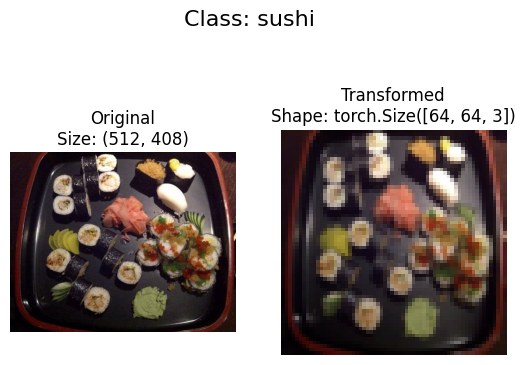

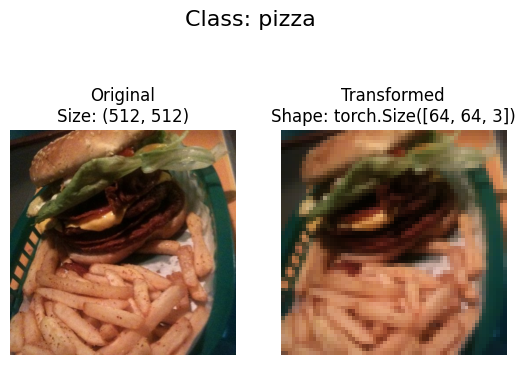

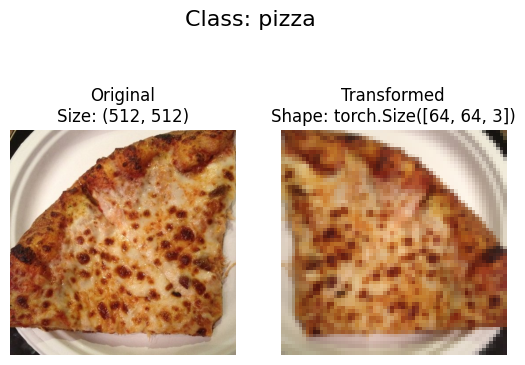

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms then plots the original vs transformed version 
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)  # Note: we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}") 
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data uding `torchvision.datasets.ImageFolder`

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None)  # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0]

print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image datatype: {label}")
print(f"Label datatype: {type(label)}")



Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

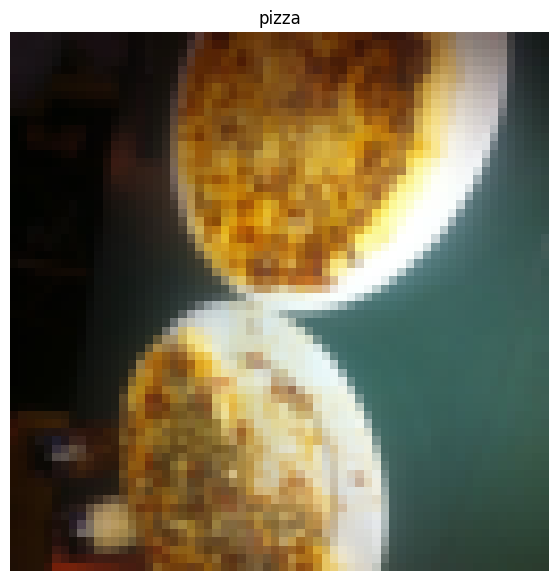

In [18]:
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis(False)

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into interables and we can customize `batch_size` so our model can see `batch_size` images at once

In [19]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

In [20]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [21]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros: 
- Can create a `Dataset` out of almost anything
- Not limited to PyTorch pre-built `Dataset` functions

Cons:
- Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
- Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We wwant a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally
the directory is in standard image classification format)
2. Raise an error if the class names aren't found (if this happends, there might be something wrong
with the directory structure).
3. Turn the class nmaes into a dict and a list and return them.

In [24]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [25]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory.
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())
    
    # Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}. Please check file structure")

    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as label)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [26]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with a target directory (the directory we'd like to get
data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    - paths: paths of our images
    - transforms: the transform we'd like to use
    - classes: a list of the target classes
    - class_to_idx: a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Override the `__len__()` method to return the length of our dataset
6. Override the `__getitem()__` method to return the given sample when passed an index

In [27]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        # Setup transforms
        self.transform = transform

        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Override __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Override __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # expects path in format: data_folder/class_name/jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx  # return data, label (X, y)
        else:
            return img, class_idx  # return untransformed image and label


In [28]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [29]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [30]:
train_data_custom.class_to_idx, test_data_custom.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [31]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [32]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop throught the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [33]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

    # 3. Set the seed 
    if seed:
        random.seed(seed)
    
    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n) 

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample, in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjusted = targ_image.permute(1, 2, 0)  # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjusted)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjusted.shape}"
        plt.title(title)

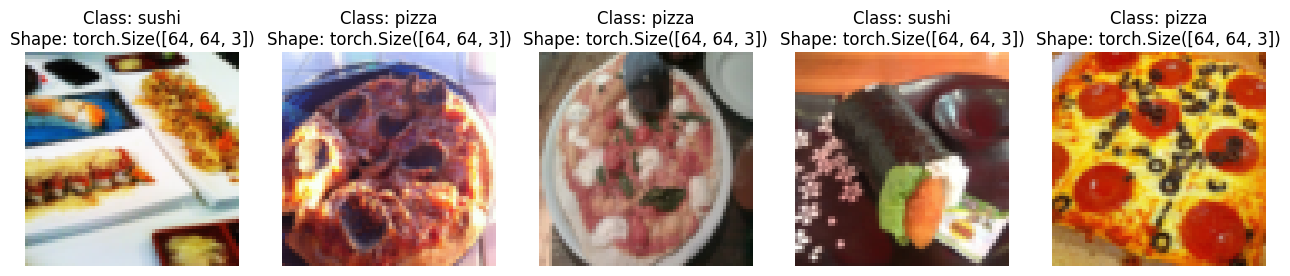

In [34]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names, 
                      seed=42) 

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


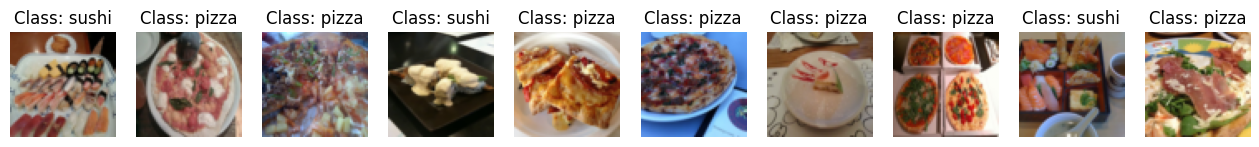

In [35]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoaders`

In [36]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [37]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to you training data.

In the case of the image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models
to state of the art levels.

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [38]:
# Let's look at trivial augment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [39]:
# Get all image paths
image_path_list = list(IMAGE_PATH.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

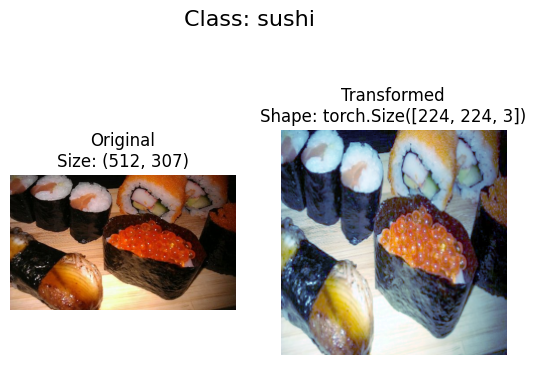

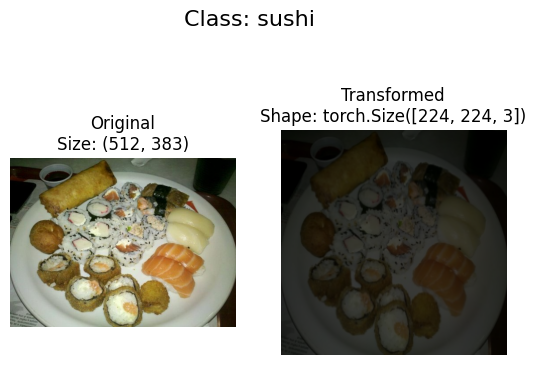

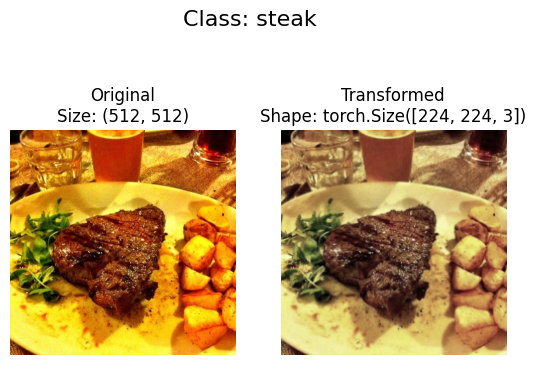

In [40]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate the TinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [41]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [42]:
from torchvision import datasets
from torch.utils.data import DataLoader

# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform,
                                  target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform,
                                 target_transform=None)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

### 7.2 Create TinyVGG model class

In [43]:
class TinyVGG(nn.Module):
    """Model architecture copying TinyVGG from CNN Explainer"""
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()  
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # default stride is same as kernel size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # default stride is same as kernel size
        )

        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifer(x)
        print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))  # benefits from operator fusion

In [44]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)